# Bayesian Neural Networks (BNNs)

In this notebook a Bayesian Neural network is trained on the CFB data to take bridge parameter as input an predict the code compliance factors.

### Resources
Here you can find nice explanations: 

1. https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/DL2/Bayesian_Neural_Networks/dl2_bnn_tut1_students_with_answers.html

The following source was used as a stating point for the implementation:

2. https://towardsdatascience.com/from-theory-to-practice-with-bayesian-neural-network-using-python-9262b611b825 

### Content
1. Data Import
2. Data Pre-processing
3. Setup and Train Model
4. Model Perfromance Evaluation
5. 1D Parameter Studies


In [1]:
#import necessary libraries
import pandas as pd
import math as m
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
from torch.utils.data import DataLoader, TensorDataset

## 1.  Data Import 

Data is imported from the defined csv file to a pandas Data Frame.

In [2]:
# Define path to csv-file
file_path="trainingData\\1000_CFB_xy.csv"

#import data from csv file
df = pd.read_csv(file_path)
df

,Unnamed: 0,ID,L,b1,t_p,t_w,h_w,d1_plate,d4_plate,d2_plate,...,x_c_shear_reduced,y_c_shear_reduced,z_c_shear_reduced,Location_c_shear_reduced,element_count_shear_reduced,eta_min_c_stresses,x_c_stresses,y_c_stresses,z_c_stresses,Location_c_stresses
0,0,0,14152.309743,13160.448316,671.877268,271.205192,2592.503458,27.287790,10.197769,25.263594,...,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
1,1,1,8837.220070,14326.857508,397.206564,392.509172,2174.579147,13.526673,28.214886,16.686438,...,9942.839110,8444.710898,-756.012123,bot,7.0,1.703969,9661.604492,4498.636719,-349.060303,eta_y_top_stresses
2,2,2,7796.803368,10387.623139,378.608748,496.703692,2499.310838,13.184702,28.695437,26.623659,...,9946.149155,0.000000,-790.995036,bot,14.0,1.116069,10201.034180,3411.216309,-331.282654,eta_y_top_stresses
3,3,3,15476.105221,16753.589316,406.201522,506.925036,4666.279702,14.948656,10.629952,23.855850,...,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
4,4,4,15734.234806,4752.154452,533.287170,1098.176839,2413.433684,28.295942,21.539489,29.983721,...,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,9995,12675.404601,15242.173399,324.831569,613.851078,4975.947365,22.126147,11.958004,20.337492,...,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
9996,9996,9996,14797.994064,10913.617015,979.049978,1080.051034,3182.345390,23.641662,13.978370,23.028303,...,9985.959569,12586.212730,0.000000,bot,0.0,4.161409,10521.542969,7351.791992,-931.291443,eta_y_top_stresses
9997,9997,9997,3812.489535,10660.380260,258.838063,1176.084953,2313.743479,21.085486,18.536990,16.966978,...,8848.115616,2418.901204,0.000000,bot,0.0,5.725578,9363.759766,1223.488770,-211.776596,eta_y_top_stresses
9998,9998,9998,8959.750469,6396.358266,815.418272,575.322936,3867.503346,18.311154,10.204305,13.407149,...,5852.667814,7692.712261,0.000000,bot,0.0,4.000414,6166.567383,4493.426270,-772.501526,eta_y_top_stresses


## 2. Pre-process Data

Pre-Processing Steps
- select x and y columns (inputs and outputs)
- split data set in trianing and test set
- transform data to same range with MinMaxScaler
- transform scaled data to troch tensors

In [3]:
###### select input and ouputs ######

#x_names = ['L', 'b1',  't_p', 't_w', 'h_w'] #5 important features
x_names = ['L', 'b1',  't_p', 't_w', 'h_w', 'd1_plate', 'd4_plate', 'd2_plate', 's_plate', 'd1_walls', 'd4_walls', 's_walls', 'fcc', 's', 'beta', 'h_G'] # all 16 features
# Select perfromances
y_names=['eta_min_c']


# Get relevant columns and transorm to torch tensors
x_data_df=df[x_names]
y_data_df=df[y_names]


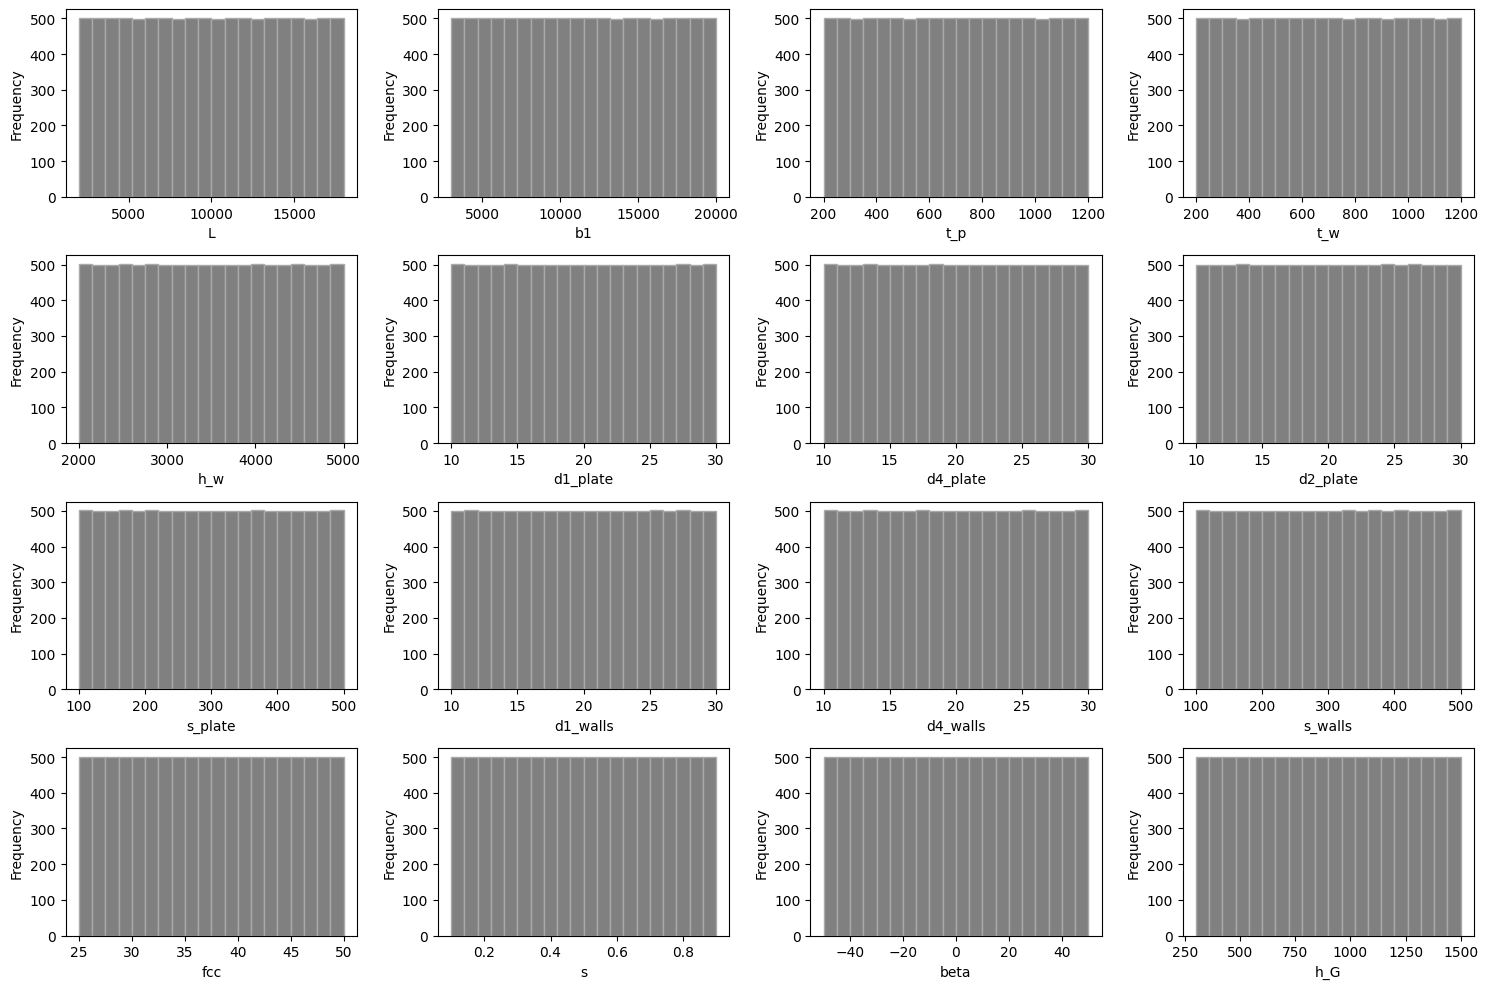

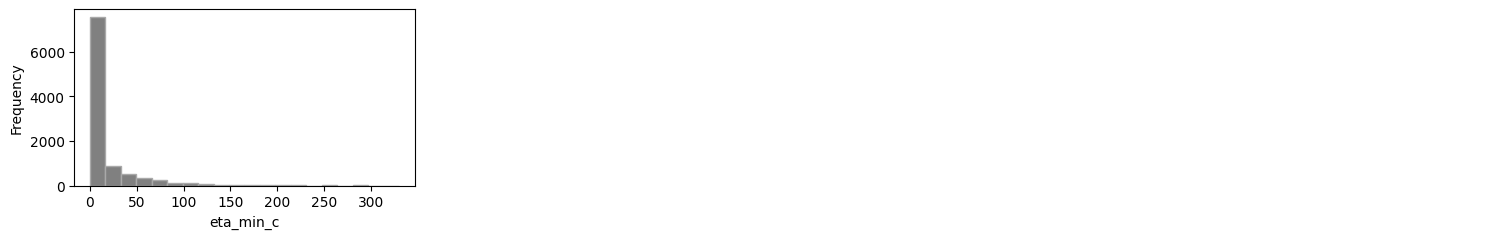

In [4]:
from plotting import hist_matrix
hist_matrix(x_data_df)
hist_matrix(y_data_df)

Training Dataset:  (6400, 16) (6400, 1)
Validation Dataset:  (1600, 16) (1600, 1)
Test Dataset:  (2000, 16) (2000, 1)


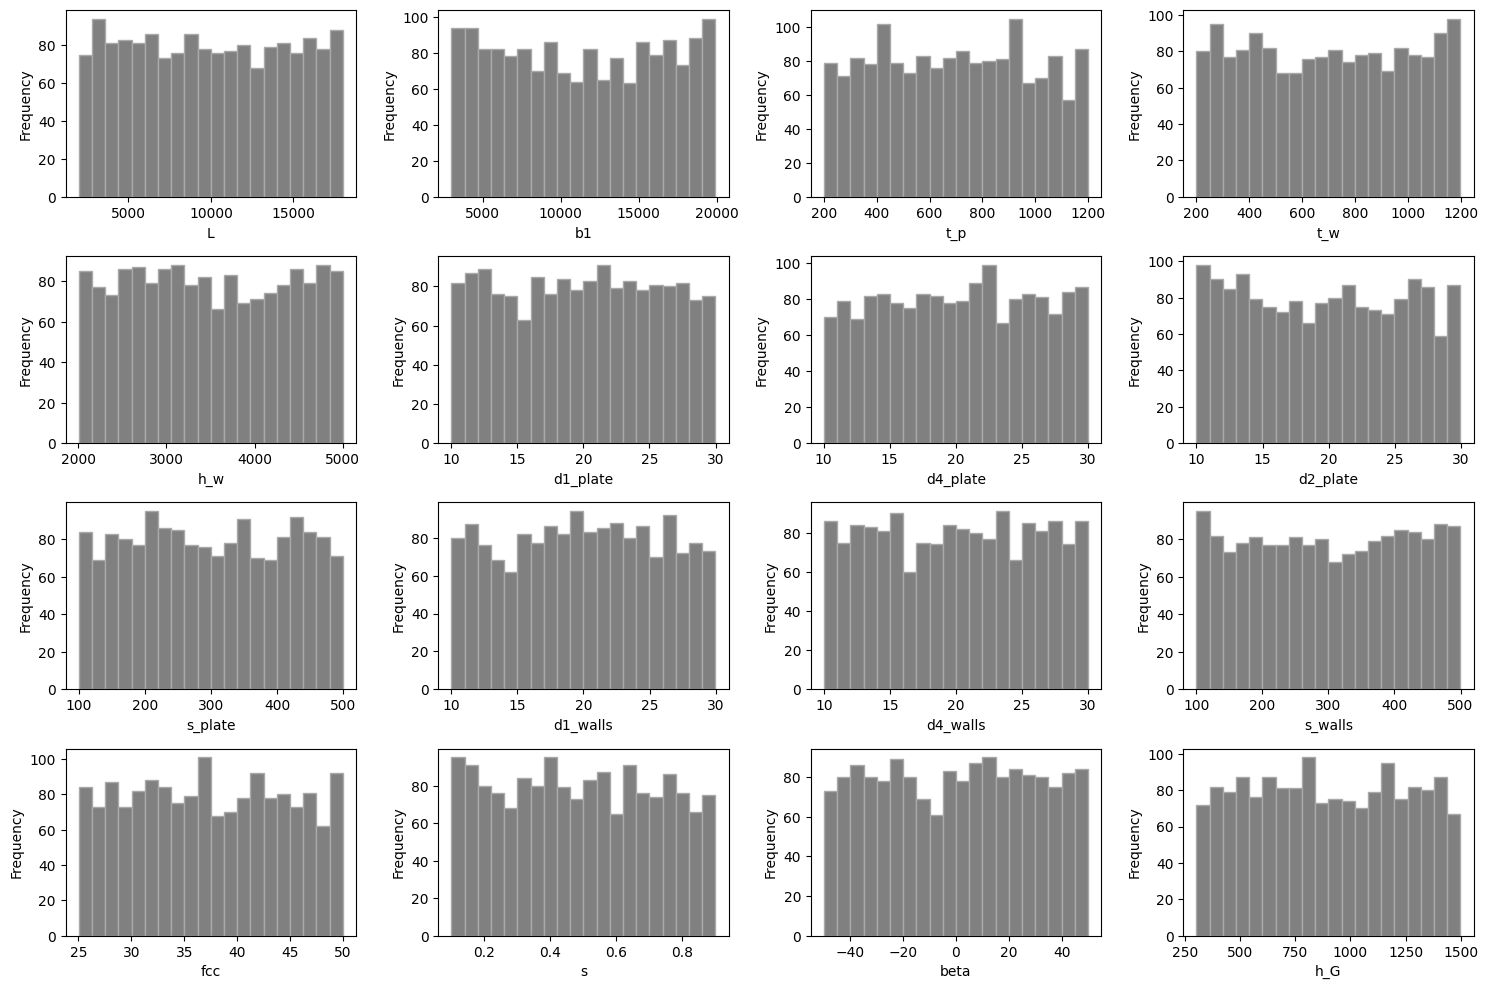

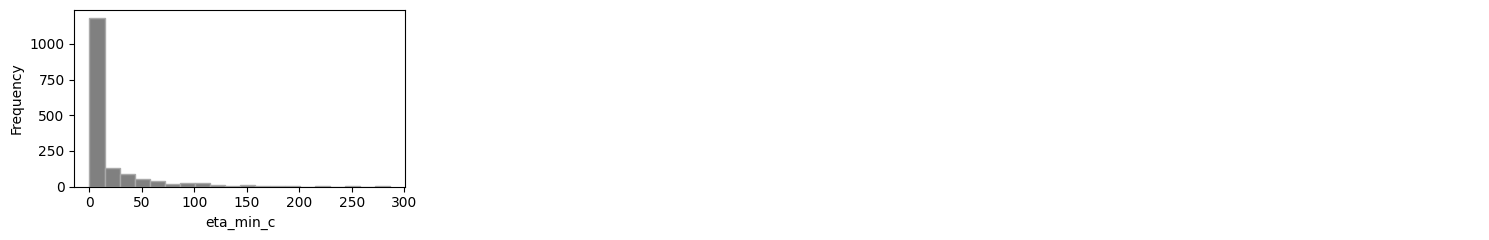

In [5]:
####### data set split #######


# split the data in training and test set
test_size = 0.2 #define test split size
x_train_full_df, x_test_df, y_train_full_df, y_test_df = train_test_split(x_data_df, y_data_df, test_size=test_size, random_state=42)

# split the training data in training and validation set
val_size = 0.2 #define val split size
x_train_df, x_val_df, y_train_df, y_val_df = train_test_split(x_train_full_df, y_train_full_df, test_size=val_size, random_state=42)

# split the data in training and test set

# transfrom to numpy arrays
x_train_np = x_train_df.values
y_train_np = y_train_df.values
x_val_np = x_val_df.values
y_val_np = y_val_df.values
x_test_np = x_test_df.values
y_test_np = y_test_df.values

#Print shapes of the splitted data sets
print('Training Dataset: ',x_train_df.shape,y_train_df.shape )
print('Validation Dataset: ',x_val_df.shape, y_val_df.shape)
print('Test Dataset: ',x_test_df.shape,y_test_df.shape)


#plot training data
hist_matrix(x_val_df)
hist_matrix(y_val_df)


In [6]:
###### Scaling of data ######

# INPUT we scale to a range 0,1
# Initialize the MinMaxScaler and fit it on the training data
# Note: MinMaxScaler  scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.
# Note: MinMaxScaler doesn’t reduce the effect of outliers, but it linearly scales them down into a fixed range
# Note: MinMaxScaler is sufficient as our data is uniformily distributed for the case when we have non-uniform distirbuted data (as sampled with )

#initialize scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# fit scaler on total data set
scaler.fit(x_data_df)

# scale training data
x_train_scaled_np = scaler.transform(x_train_df)
x_train_scaled_df=pd.DataFrame(data=x_train_scaled_np, columns=scaler.get_feature_names_out())

# Scale the validation data using the same scaler
x_val_scaled_np = scaler.transform(x_val_df)
x_val_scaled_df=pd.DataFrame(data=x_val_scaled_np, columns=scaler.get_feature_names_out())

# Scale the validation data using the same scaler
x_test_scaled_np = scaler.transform(x_test_df)
x_test_scaled_df=pd.DataFrame(data=x_test_scaled_np, columns=scaler.get_feature_names_out())

#plot scaled data
x_train_scaled_df.describe()

,L,b1,t_p,t_w,h_w,d1_plate,d4_plate,d2_plate,s_plate,d1_walls,d4_walls,s_walls,fcc,s,beta,h_G
count,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000
mean,0.498005,0.502608,0.498070,0.501119,0.500142,0.500351,0.495784,0.503906,0.501885,0.500685,0.499561,0.501656,0.497542,0.502634,0.499488,0.500388
std,0.286519,0.286590,0.288831,0.287781,0.287729,0.287379,0.288648,0.286804,0.290600,0.291063,0.289466,0.286489,0.289219,0.287873,0.290233,0.289131
min,0.000017,0.000000,0.000000,0.000222,0.000126,0.000129,0.000000,0.000131,0.000000,0.000000,0.000000,0.000096,0.000000,0.000075,0.000000,0.000079
25%,0.250183,0.255347,0.249695,0.252991,0.250598,0.254077,0.244463,0.257190,0.247977,0.247181,0.246539,0.252560,0.246018,0.253260,0.246744,0.249071
50%,0.498695,0.503167,0.495692,0.500814,0.501378,0.499384,0.492479,0.506774,0.504629,0.499316,0.500485,0.504073,0.499432,0.498569,0.496093,0.501902
75%,0.744232,0.750352,0.748797,0.750664,0.748302,0.748891,0.747102,0.749794,0.754620,0.756960,0.751842,0.748605,0.748960,0.752789,0.754131,0.750859
max,1.000000,0.999931,1.000000,1.000000,0.999943,1.000000,0.999656,0.999938,0.999861,0.999907,1.000000,0.999783,1.000000,0.999701,0.999844,1.000000


In [7]:
# Note instead of scaling the data here I inlcuded a mean squared log error loss in my training which has the same effect but no need for preprocessing and postprocing of training input and prediction output
# ###### Scaling of data ######

# # Y (Output) we scale with log(y)
# #m.log(y_train_np)

# # Applying y_trans=log_e(y+1) function/ transformation
# y_train_transf_np = np.log(y_train_np + 1) # log_e
# y_train_transf_df=pd.DataFrame(y_train_transf_np, columns=y_names)

# y_val_transf_np = np.log(y_val_np + 1) # log_e
# y_val_transf_df=pd.DataFrame(y_val_transf_np, columns=y_names)


# hist_matrix(y_train_transf_df)


# ##### convert to troch tensors ######

# # convert data to toch tensors (as needed format for BNN model)
# x_train_scaled_tensor=torch.tensor(x_train_scaled_df.values, dtype=torch.float32)
# y_train_transf_tensor=torch.tensor(y_train_transf_df.values, dtype=torch.float32)

# x_val_scaled_tensor=torch.tensor(x_val_scaled_df.values, dtype=torch.float32)
# y_val_transf_tensor=torch.tensor(y_val_transf_df.values, dtype=torch.float32)

In [8]:
##### convert to troch tensors ######

# convert data to toch tensors (as needed format for BNN model)
#training data
x_train_scaled_tensor=torch.tensor(x_train_scaled_df.values, dtype=torch.float32)
y_train_tensor=torch.tensor(y_train_df.values, dtype=torch.float32)

#validation data
x_val_scaled_tensor=torch.tensor(x_val_scaled_df.values, dtype=torch.float32)
y_val_tensor=torch.tensor(y_val_df.values, dtype=torch.float32)

#test data
x_test_scaled_tensor=torch.tensor(x_test_scaled_df.values, dtype=torch.float32)
y_test_tensor=torch.tensor(y_test_df.values, dtype=torch.float32)


## 3. Setup and Train Model

- Define NN Architecture
- Define Losses
- Training Loop
- Plot loss developement during trianing
- save trained model

In [10]:
# define NN architecture
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=16, out_features=20),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=20, out_features=20),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=20, out_features=1),
    nn.ReLU()
)


#initialize error tracking lists
#TODO I think these need to be new initialised when the model is redefined. 
# Otherwise they should not always be initialised when the training is started. because we could have the case that a pretrained model is trainied for some more epochs.
mse_list=[]
mse_val_list=[]

msle_list=[]
msle_val_list=[]

mean_mse_list=[]
mean_mse_val_list=[]

custom_mse_list = []
custom_mse_val_list = []

rmse_list=[]
rmse_val_list=[]

kl_list=[]
kl_val_list=[]


In [11]:
##### Losses ######

# define kl weight for weighing of kl_loss in total loss function
# Note: depending which loss function are used different kl_weights should be chosen...msle is of a multiple magnitude smaller than the mse, so the kl_weight hast to also be adapter when we use that weight.
# Note: with mse loss 0.01, with msle loss 0.0001
kl_weight = 0.001
# get kl loss
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)

# get mse loss
mse_loss = nn.MSELoss()

#define custom loss function
def weighted_mse_loss(predictions, targets, importance_range=(0, 5), high_weight=10):
    # Calculate the basic MSE loss
    basic_mse = (predictions - targets) ** 2

    # Apply a higher weight to errors within the specified range
    weights = torch.ones_like(targets)
    weights[(targets >= importance_range[0]) & (targets <= importance_range[1])] = high_weight

    # Calculate the weighted MSE loss
    weighted_mse = basic_mse * weights
    return weighted_mse.mean()

# mean_squared_log_error
def msle_loss(pred, targets, base='e'):
    
    if base=='e':
        pred_scaled = torch.log(pred + 1) 
        targets_scaled = torch.log(targets + 1) 
    elif base ==10 or base =='10':
        pred_scaled = torch.log10(pred + 1) 
        targets_scaled = torch.log10(targets + 1) 
    else:
        raise Exception('Invalid input for base parameter.')


    
    # Calculate the MSE loss
    msle = ((pred_scaled - targets_scaled ) ** 2).mean()

    return msle

#get optimizer
learning_rate=0.01
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
# define epochs, and the training data, and the batch size
epochs = 1000
batch_size = 32
# Shuffle is set to True to randomize the order of training data at each epoch

train_dataset = TensorDataset(x_train_scaled_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# x = x_train_scaled_tensor
# y = y_train_transf_tensor
with_stochasticPrediction=False

#training loop
for step in range(epochs):
    
    model.train()

    epoch_mse = []
    epoch_msle = []
    epoch_custom_mse = []
    epoch_rmse = []
    epoch_kl = []

    for x, y in train_loader:
        y_pred = model(x)

        if with_stochasticPrediction:
            y_pred_mean_np, y_pred_std_np, y_pred_n_times=bnn_predict_with_uncertainty(model, x, n=100)
            y_pred_mean_tensor=torch.tensor(y_pred_mean_np, dtype=torch.float32)
            mean_mse = mse_loss(y_pred_mean_tensor, y)
            mean_mse_list.append(mean_mse.item())
            
        #standard mse, rmse loss
        mse = mse_loss(y_pred, y)
        epoch_mse.append(mse.item())
        # mse_list.append(mse.item())
        rmse = torch.sqrt(mse)
        epoch_rmse.append(rmse.item())

        #msle los
        msle = msle_loss(y_pred, y,base='10')
        epoch_msle.append(msle.item())
        # msle_list.append(msle.item())

        # Custom weighted MSE loss
        custom_mse = weighted_mse_loss(y_pred, y, importance_range=(0, 4), high_weight=10)
        epoch_custom_mse.append(custom_mse.item())
        # custom_mse_list.append(custom_mse.item())

        #kl_divergence loss
        kl = kl_loss(model)
        epoch_kl.append(kl.item())
        # kl_list.append(kl.item())

        # Add individual losses weighted to single loss
        cost = rmse + kl_weight*kl
        cost_log=msle + kl_weight*kl
        cost_custom = custom_mse + kl_weight*kl
        
        optimizer.zero_grad()
        cost_log.backward()
        optimizer.step()

    # Calculate mean losses for the epoch (on training data) and save in loss lists
    mse_list.append(np.mean(epoch_mse))
    rmse_list.append(np.mean(epoch_rmse))
    msle_list.append(np.mean(epoch_msle))
    custom_mse_list.append(np.mean(epoch_custom_mse))
    kl_list.append(np.mean(epoch_kl))

    # Calculate validation loss calculation and save in loss tracking lists
    model.eval()
    with torch.no_grad():
        y_val_pred = model(x_val_scaled_tensor)

        #standard mse, rmse loss
        mse_val = mse_loss(y_val_pred, y_val_tensor)
        mse_val_list.append(mse_val.item())
        rmse_val = torch.sqrt(mse_val)
        rmse_val_list.append(rmse_val.item())

        #msle los
        msle_val = msle_loss(y_val_pred, y_val_tensor, base='10')
        msle_val_list.append(msle_val.item())

        # Custom weighted MSE loss
        custom_mse_val = weighted_mse_loss(y_val_pred, y_val_tensor, importance_range=(0, 4), high_weight=10)
        custom_mse_val_list.append(custom_mse_val.item())


    #verbalise
    if step % 50 == 0:
        if with_stochasticPrediction:
            print(f'Step {step}, MSE: {mse.item():.2f}, Mean MSE: {mean_mse.item():.2f}, MSLE: {msle.item():.2f}, KL: {kl.item():.2f}, RMSE: {rmse.item():.2f}, Custom MSE: {custom_mse.item():.2f}',
                  f'Val MSE: {mse_val.item():.2f}, Val MSLE: {msle_val.item():.2f}, Val RMSE: {rmse_val.item():.2f}, Val Custom MSE: {custom_mse_val.item():.2f}')
        else: 
            print(f'Step {step}, MSE: {mse.item():.2f}, MSLE: {msle.item():.2f}, KL: {kl.item():.2f}, RMSE: {rmse.item():.2f}, Custom MSE: {custom_mse.item():.2f}',
                  f'Val MSE: {mse_val.item():.2f}, Val MSLE: {msle_val.item():.2f}, Val RMSE: {rmse_val.item():.2f}, Val Custom MSE: {custom_mse_val.item():.2f}')
    


print('Training is finished. The final losses:') 
if with_stochasticPrediction:
    print(f'Step {step}, MSE: {mse.item():.2f}, Mean MSE: {mean_mse.item():.2f}, MSLE: {msle.item():.2f},KL: {kl.item():.2f}, RMSE: {rmse.item():.2f}, Custom MSE: {custom_mse.item():.2f}',
          f'Val MSE: {mse_val.item():.2f}, Val MSLE: {msle_val.item():.2f}, Val RMSE: {rmse_val.item():.2f}, Val Custom MSE: {custom_mse_val.item():.2f}')
else:
    print(f'Step {step}, MSE: {mse.item():.2f}, MSLE: {msle.item():.2f}, KL: {kl.item():.2f}, RMSE: {rmse.item():.2f}, Custom MSE: {custom_mse.item():.2f}',
          f'Val MSE: {mse_val.item():.2f}, Val MSLE: {msle_val.item():.2f}, Val RMSE: {rmse_val.item():.2f}, Val Custom MSE: {custom_mse_val.item():.2f}')

Step 0, MSE: 481.71, MSLE: 0.10, KL: 4.44, RMSE: 21.95, Custom MSE: 488.09 Val MSE: 755.12, Val MSLE: 0.12, Val RMSE: 27.48, Val Custom MSE: 791.23
Step 50, MSE: 54.90, MSLE: 0.01, KL: 13.41, RMSE: 7.41, Custom MSE: 56.06 Val MSE: 213.37, Val MSLE: 0.03, Val RMSE: 14.61, Val Custom MSE: 218.92
Step 100, MSE: 186.82, MSLE: 0.01, KL: 13.33, RMSE: 13.67, Custom MSE: 187.79 Val MSE: 231.48, Val MSLE: 0.03, Val RMSE: 15.21, Val Custom MSE: 236.20
Step 150, MSE: 16.13, MSLE: 0.02, KL: 13.34, RMSE: 4.02, Custom MSE: 18.89 Val MSE: 205.46, Val MSLE: 0.03, Val RMSE: 14.33, Val Custom MSE: 211.53
Step 200, MSE: 77.50, MSLE: 0.02, KL: 13.45, RMSE: 8.80, Custom MSE: 86.53 Val MSE: 244.03, Val MSLE: 0.03, Val RMSE: 15.62, Val Custom MSE: 250.07
Step 250, MSE: 398.48, MSLE: 0.03, KL: 13.39, RMSE: 19.96, Custom MSE: 400.15 Val MSE: 235.11, Val MSLE: 0.03, Val RMSE: 15.33, Val Custom MSE: 240.06
Step 300, MSE: 17.52, MSLE: 0.01, KL: 13.56, RMSE: 4.19, Custom MSE: 22.47 Val MSE: 218.23, Val MSLE: 0.03,

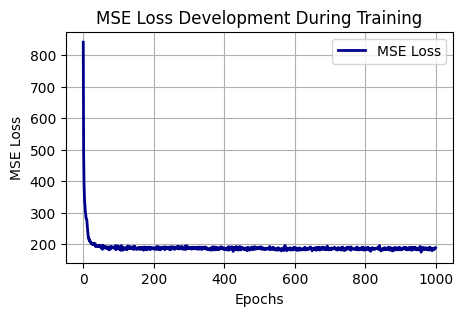

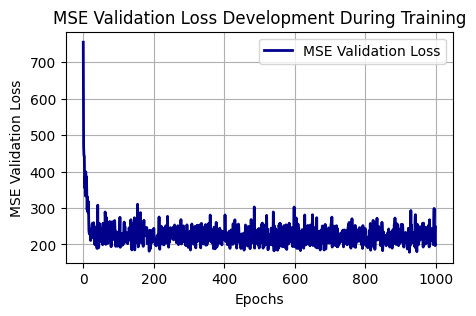

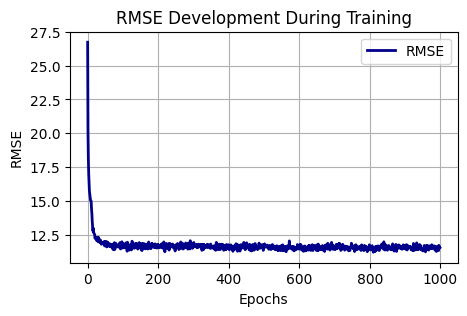

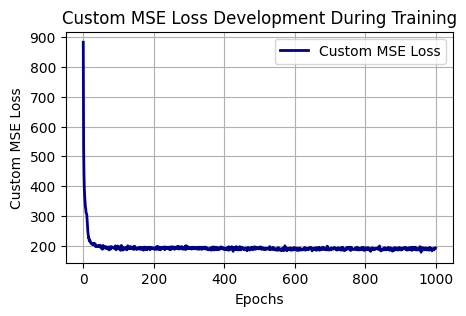

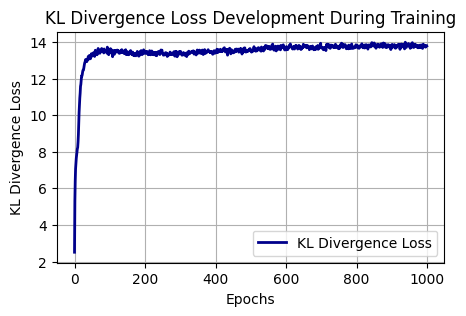

In [13]:
from plotting import plot_loss_development

loss_lists = [mse_list, mse_val_list, rmse_list, custom_mse_list, kl_list]
# loss_lists = [mse_list, mean_mse_list, kl_list, rmse_list, custom_mse_list]
loss_names = ['MSE Loss', 'MSE Validation Loss', 'RMSE', 'Custom MSE Loss', 'KL Divergence Loss',]
# loss_names = ['MSE Loss', 'Mean MSE Loss', 'KL Divergence Loss', 'RMSE', 'Custom MSE Loss']

# Define a path to save the plots, if needed
save_path = 'trainedModels' # Example path, change it as needed

plot_loss_development(loss_lists, loss_names, save_path, color='darkblue', model_name='TestModel', figsize=(5, 3))

In [14]:
####### save model #######
# define model name
name_training_run='RunTest'

#saving the whole model
torch.save(model, 'trainedModels\\'+name_training_run+'.pth')

#saving just the weights and biases
#torch.save(model.state_dict(), 'trainedModels\\'+name_training_run+'.pth')

## 4. Model evaluation
- load model
- On training data:

    a. evaluate prediction perfromance

    b. evaluate uncertanty calibration

- On validation data:

    a. evaluate prediction perfromance

    b. evaluate uncertanty calibration

- On test data: 

    a. evaluate prediction perfromance

    b. evaluate uncertanty calibration
    


In [9]:
## load a model
name_training_run='RunTest'
model = torch.load('trainedModels\\'+name_training_run+'.pth')

model.eval() # sets the model to evaluation mode, which affects layers like dropout and batch normalization that behave differently during training and inference.
model

C:\Users\bingg\AppData\Local\Temp\ipykernel_5144\1581655195.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('trainedModels\\'+name_training_run+'.pth'

Sequential(
  (0): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=16, out_features=20, bias=True)
  (1): ReLU()
  (2): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=20, out_features=20, bias=True)
  (3): ReLU()
  (4): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=20, out_features=1, bias=True)
  (5): ReLU()
)

In [10]:
from plotting import plot_true_vs_pred, single_para_strudy_perf
from MLmodel import bnn_predict_with_uncertainty, calculate_rmse, filter_values_within_range

### On the training data

In [11]:
##### make predictions #####
# Define number of predictions
n_predictions = 1000

# Perfrom multiple predictions on data --> get mean and std for each data point
y_train_mean_pred_np, y_train_std_pred_np, y_train_pred_n_times = bnn_predict_with_uncertainty(model, x_train_scaled_tensor, n=n_predictions, log_transform_back=False)
# print('Mean Predictions: ', y_train_mean_pred_np)
# print('Standard Deviation of Predictions: ', y_train_std_pred_np)

Text(0, 0.5, 'Probability density')

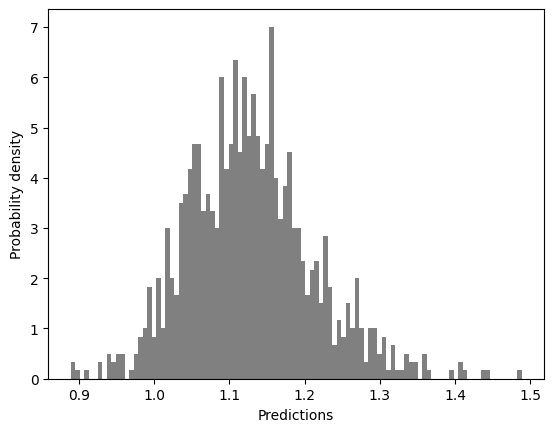

In [12]:
#plot predictive distribution
sample=30

y_train_pred_n_times

fig, ax = plt.subplots()
num_bins = 100
# the histogram of the actual error distribution
n, bins, patches = ax.hist(y_train_pred_n_times[sample].flatten(), num_bins, density=True, label='Observed histogram', color='gray')
ax.set_xlabel('Predictions')
ax.set_ylabel('Probability density')

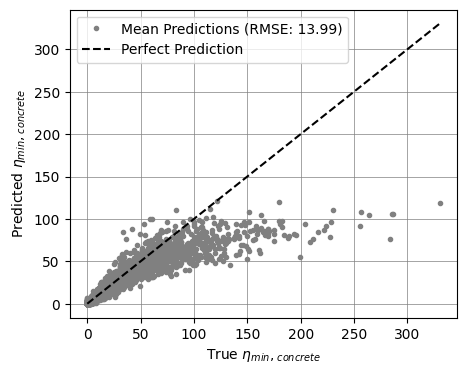

In [13]:
###### Calulate Metrics and Plot #######

# Calculate rmse
rmse_train = calculate_rmse(y_train_np, y_train_mean_pred_np)
# print("Root Mean Squared Error (RMSE):", rmse_train)

#plot True vs Pred Plot
plot_true_vs_pred(y_true=y_train_np, y_pred=y_train_mean_pred_np, rmse_value=rmse_train, y_name='$\eta_{min},_{concrete}$' )

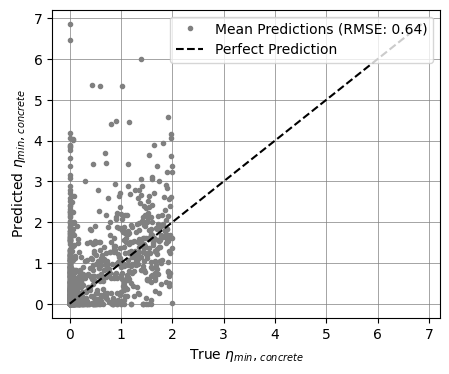

In [14]:
###### Calulate Metrics and Plot: For Critical Range #######

# Define the range
lower_bound = 0
upper_bound = 2

filtered_y_train_np, filtered_y_train_mean_pred_np=filter_values_within_range(y_true=y_train_np, y_pred=y_train_mean_pred_np, lb=lower_bound, ub=upper_bound)

# Calculate rmse
rmse_train_filtered = calculate_rmse(filtered_y_train_np, filtered_y_train_mean_pred_np)

#plot True vs Pred Plot
plot_true_vs_pred(y_true=filtered_y_train_np, y_pred=filtered_y_train_mean_pred_np, rmse_value=rmse_train_filtered, 
                    y_name='$\eta_{min},_{concrete}$' )



Text(0, 0.5, 'Probability density')

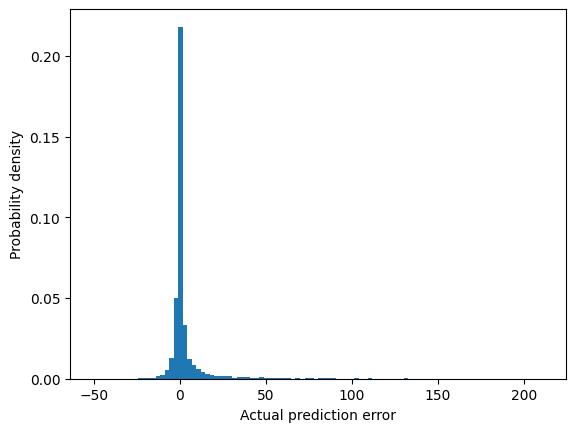

In [15]:
# calculating errors of the average model and plot them
errors=y_train_np - y_train_mean_pred_np

fig, ax = plt.subplots()
num_bins = 100
# the histogram of the actual error distribution
n, bins, patches = ax.hist(errors.flatten(), num_bins, density=True, label='Observed histogram')
ax.set_xlabel('Actual prediction error')
ax.set_ylabel('Probability density')

#### Evaluation of Uncertanty Calibration 

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


# Define a range of confidence levels
confidence_levels = np.linspace(0, 1, 100)
coverages = []

# Compute prediction intervals (e.g., 95% confidence intervals) (Assumption that the predictive distribution is a normal dirtsibution)
for confidence_level in confidence_levels:
    z = norm.ppf((1 + confidence_level) / 2)  # z-score for the confidence level
    prediction_intervals = np.array([
        [meanPred - z * std, meanPred + z * std]
        for meanPred, std in zip(y_train_mean_pred_np, y_train_std_pred_np)
    ])

    # Check if actual values fall within prediction intervals
    within_intervals = np.array([
        interval[0] <= y_true <= interval[1]
        for interval, y_true in zip(prediction_intervals, y_train_np)
    ])
    
    # Proportion of times actual values fall within prediction intervals
    coverage = np.mean(within_intervals)
    coverages.append(coverage)

print(coverages)

[0.23359375, 0.23421875, 0.235, 0.236875, 0.2396875, 0.24125, 0.2425, 0.2440625, 0.245625, 0.2471875, 0.24859375, 0.249375, 0.25046875, 0.2515625, 0.2525, 0.25375, 0.25453125, 0.25515625, 0.25625, 0.2571875, 0.25796875, 0.25859375, 0.2596875, 0.2609375, 0.2615625, 0.2625, 0.26390625, 0.2659375, 0.26703125, 0.268125, 0.26875, 0.2696875, 0.27046875, 0.2715625, 0.2725, 0.27328125, 0.2740625, 0.2746875, 0.27546875, 0.27640625, 0.2775, 0.2790625, 0.28, 0.28078125, 0.28171875, 0.2828125, 0.28390625, 0.285, 0.2859375, 0.2871875, 0.28765625, 0.2890625, 0.29015625, 0.291875, 0.29359375, 0.29484375, 0.2959375, 0.29625, 0.29671875, 0.29796875, 0.29859375, 0.29984375, 0.30125, 0.30203125, 0.3034375, 0.304375, 0.305, 0.30625, 0.306875, 0.30875, 0.31140625, 0.313125, 0.31484375, 0.31734375, 0.31828125, 0.32078125, 0.32296875, 0.32515625, 0.3275, 0.3303125, 0.3334375, 0.33671875, 0.33828125, 0.3403125, 0.34265625, 0.345, 0.34765625, 0.35078125, 0.3528125, 0.35546875, 0.3578125, 0.36078125, 0.3653125,

C:\Users\bingg\AppData\Local\Temp\ipykernel_5144\3755510431.py:14: RuntimeWarning: invalid value encountered in multiply
  [meanPred - z * std, meanPred + z * std]


In [17]:
from sklearn.metrics import mean_squared_error
# Calculate Brier score
brier_score = mean_squared_error(confidence_levels, coverages)
print("Brier score:", brier_score)

# Calculate Expected Calibration Error (ECE)
ece = np.mean(np.abs(confidence_levels - coverages))
print("Expected Calibration Error (ECE):", ece)

# Calculate Total Calibration Error (TCE)
tce = np.sum(np.abs(confidence_levels - coverages))
print("Total Calibration Error (TCE):", tce)

# Calculate Bias (Positive for Overconfidence, Negative for Underconfidence)
bias = np.sum(confidence_levels - coverages)
print("Calibration Bias:", bias)

Brier score: 0.10223197745192815
Expected Calibration Error (ECE): 0.2653909090909092
Total Calibration Error (TCE): 26.539090909090916
Calibration Bias: 20.120937500000004


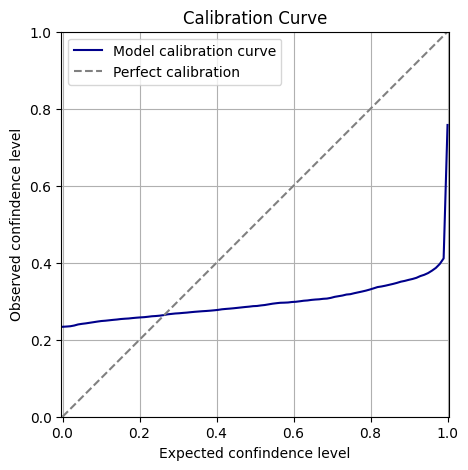

In [18]:
# Plot the calibration curve
plt.figure(figsize=(5, 5))
plt.plot(confidence_levels, coverages,  label='Model calibration curve', color='darkblue')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect calibration',color='gray')
# plt.plot(p_pred, p_obs, label='Model calibration curve')
# plt.plot([0,1],[0,1], 'k--', alpha=0.6, label='Ideal calibration curve')
plt.xlabel('Expected confindence level')
plt.ylabel('Observed confindence level')
plt.title('Calibration Curve')
plt.axis('equal')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# # TODO: Implementation in a function of uncertanty calibration calulation 
# # BUT for some reason this runs 2 minutes, while the not function code runs 10 seconds...correct this 
# # the results seem to be the same...

# import numpy as np
# from scipy.stats import norm

# # Define the function to calculate a confidence interval for a normal distribution
# def calc_confidence_interval_snorm(confidence_level, mean_pred, std_pred):
#     z = norm.ppf((1 + confidence_level) / 2)  # z-score for the confidence level
#     confidence_interval = [mean_pred - z * std_pred, mean_pred + z * std_pred]

#     return confidence_interval

# # Define the function to calculate the cobserved confidence level (coverage)
# def calc_observed_confidence(confidence_level, y_pred_mean, y_pred_std, y_true):
#     confidence_intervals = np.array([
#         calc_confidence_interval_snorm(confidence_level, mean_pred, std_pred)
#         for mean_pred, std_pred in zip(y_pred_mean, y_pred_std)
#     ])

#     # Check if actual values fall within prediction intervals
#     within_intervals = np.array([
#         interval[0] <= true_val <= interval[1]
#         for interval, true_val in zip(confidence_intervals, y_true)
#     ])

#     coverage = np.mean(within_intervals)
#     return coverage



# # Define a range of confidence levels
# confidence_levels = np.linspace(0, 1, 100)
# coverages = []

# # Compute prediction intervals and check coverage
# for confidence_level in confidence_levels:
#     coverage = calc_observed_confidence(confidence_level, y_train_mean_pred_np, y_train_std_pred_np, y_train_np)
#     coverages.append(coverage)

# print("Coverages for each confidence level:", coverages)

In [20]:
# from fitter import Fitter
#Idea: with current uncertanty callibaration we assume a stand. normal distribution for our model predictions to calculate the confidence interval
# one could also do this more accurately, so fit a distribution to the predicted distributin and calculate confidence intervalls from that distribution
# or take the n predictions, and find (iteratively) the confidence intervals (timeconsuming?)

# f = Fitter(y_train_pred_n_times[1],
#            distributions=['gamma',
#                           'lognorm',
#                           "beta",
#                           "burr",
#                           "norm"])
# f.fit()
# f.summary()
# f.get_best(method = 'sumsquare_error')

#### on the validation data:

In [21]:
##### make predictions ####
# Define number of predictions
n_predictions = 1000

# Perfrom multiple predictions on data --> get mean and std for each data point
y_val_mean_pred_np, y_val_std_pred_np, y_val_pred_n_times = bnn_predict_with_uncertainty(model, x_val_scaled_tensor, n=n_predictions,log_transform_back=False)
y_val_mean_pred_np

array([[ 0.       ],
       [ 0.       ],
       [ 8.558485 ],
       ...,
       [62.827774 ],
       [ 2.8082728],
       [60.54503  ]], dtype=float32)

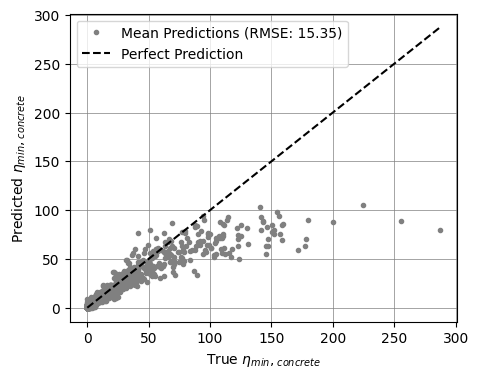

In [22]:
###### Calulate Metrics and Plot #######

# Calculate rmse
rmse_val = calculate_rmse(y_val_np, y_val_mean_pred_np)

#plot True vs Pred Plot
plot_true_vs_pred(y_true=y_val_np, y_pred=y_val_mean_pred_np, rmse_value=rmse_val, y_name='$\eta_{min},_{concrete}$' )

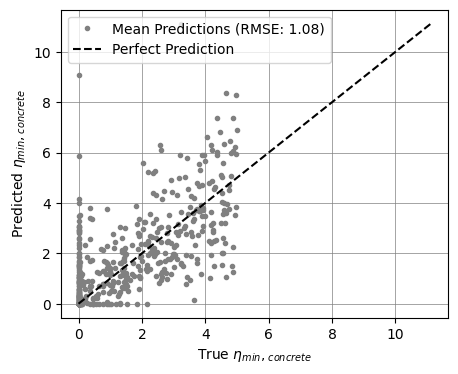

In [23]:
###### Calulate Metrics and Plot: For Critical Range #######

# Define the range
lower_bound = 0
upper_bound = 5

filtered_y_val_np, filtered_y_val_mean_pred_np=filter_values_within_range(y_true=y_val_np, y_pred=y_val_mean_pred_np, lb=lower_bound, ub=upper_bound)

# Calculate rmse
rmse_val_filtered = calculate_rmse(filtered_y_val_np, filtered_y_val_mean_pred_np)

#plot True vs Pred Plot
plot_true_vs_pred(y_true=filtered_y_val_np, y_pred=filtered_y_val_mean_pred_np, rmse_value=rmse_val_filtered, 
                    y_name='$\eta_{min},_{concrete}$' )

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


# Define a range of confidence levels
confidence_levels = np.linspace(0, 1, 100)
coverages = []

# Compute prediction intervals (e.g., 95% confidence intervals) (Assumption that the predictive distribution is a normal dirtsibution)
for confidence_level in confidence_levels:
    z = norm.ppf((1 + confidence_level) / 2)  # z-score for the confidence level
    prediction_intervals = np.array([
        [meanPred - z * std, meanPred + z * std]
        for meanPred, std in zip(y_val_mean_pred_np, y_val_std_pred_np)
    ])

    # Check if actual values fall within prediction intervals
    within_intervals = np.array([
        interval[0] <= y_true <= interval[1]
        for interval, y_true in zip(prediction_intervals, y_val_np)
    ])
    
    # Proportion of times actual values fall within prediction intervals
    coverage = np.mean(within_intervals)
    coverages.append(coverage)

print(coverages)

[0.241875, 0.241875, 0.2425, 0.245, 0.246875, 0.250625, 0.2525, 0.255, 0.255, 0.25625, 0.258125, 0.26, 0.26125, 0.2625, 0.2625, 0.263125, 0.264375, 0.264375, 0.265, 0.265, 0.26625, 0.268125, 0.27, 0.270625, 0.270625, 0.2725, 0.27375, 0.274375, 0.275625, 0.276875, 0.278125, 0.28, 0.280625, 0.281875, 0.281875, 0.281875, 0.281875, 0.283125, 0.28375, 0.286875, 0.2875, 0.29, 0.29, 0.290625, 0.29125, 0.2925, 0.295, 0.29625, 0.29625, 0.29625, 0.298125, 0.29875, 0.299375, 0.299375, 0.30125, 0.30125, 0.301875, 0.303125, 0.305, 0.3075, 0.30875, 0.309375, 0.311875, 0.3125, 0.3125, 0.31375, 0.31375, 0.31375, 0.315, 0.316875, 0.319375, 0.321875, 0.3225, 0.324375, 0.326875, 0.3275, 0.330625, 0.33125, 0.333125, 0.334375, 0.335625, 0.336875, 0.338125, 0.34125, 0.343125, 0.34375, 0.34375, 0.345, 0.345625, 0.34875, 0.3525, 0.355, 0.36, 0.36625, 0.368125, 0.37, 0.375625, 0.388125, 0.404375, 0.749375]


C:\Users\bingg\AppData\Local\Temp\ipykernel_5144\3651735814.py:14: RuntimeWarning: invalid value encountered in multiply
  [meanPred - z * std, meanPred + z * std]


In [25]:
from sklearn.metrics import mean_squared_error
# Calculate Brier score
brier_score = mean_squared_error(confidence_levels, coverages)
print("Brier score:", brier_score)

# Calculate Expected Calibration Error (ECE)
ece = np.mean(np.abs(confidence_levels - coverages))
print("Expected Calibration Error (ECE):", ece)

# Calculate Total Calibration Error (TCE)
tce = np.sum(np.abs(confidence_levels - coverages))
print("Total Calibration Error (TCE):", tce)

# Calculate Bias (Positive for Overconfidence, Negative for Underconfidence)
bias = np.sum(confidence_levels - coverages)
print("Calibration Bias:", bias)

Brier score: 0.10170369991582494
Expected Calibration Error (ECE): 0.26418636363636366
Total Calibration Error (TCE): 26.418636363636367
Calibration Bias: 19.495000000000005


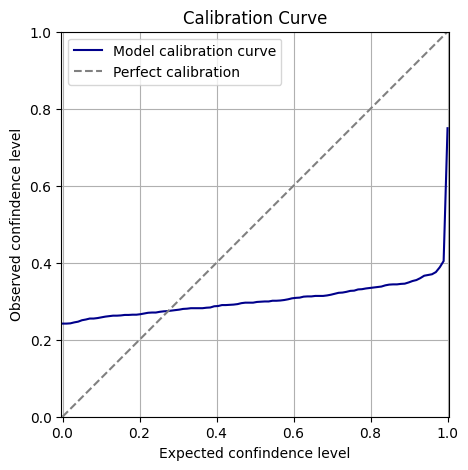

In [26]:
# Plot the calibration curve
plt.figure(figsize=(5, 5))
plt.plot(confidence_levels, coverages,  label='Model calibration curve', color='darkblue')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect calibration',color='gray')
# plt.plot(p_pred, p_obs, label='Model calibration curve')
# plt.plot([0,1],[0,1], 'k--', alpha=0.6, label='Ideal calibration curve')
plt.xlabel('Expected confindence level')
plt.ylabel('Observed confindence level')
plt.title('Calibration Curve')
plt.axis('equal')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.grid(True)
plt.show()

#### on test data

In [27]:
##### make predictions ####
# Define number of predictions
n_predictions = 1000

# Perfrom multiple predictions on data --> get mean and std for each data point
y_test_mean_pred_np, y_test_std_pred_np, y_test_pred_n_times = bnn_predict_with_uncertainty(model, x_test_scaled_tensor, n=n_predictions,log_transform_back=False)
y_test_mean_pred_np

array([[0.0000000e+00],
       [0.0000000e+00],
       [1.8314278e+01],
       ...,
       [3.8612633e+01],
       [3.8633358e+00],
       [3.6176231e-02]], dtype=float32)

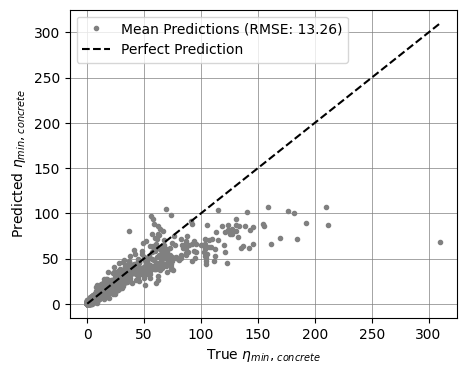

In [28]:
###### Calulate Metrics and Plot #######

# Calculate rmse
rmse_test = calculate_rmse(y_test_np, y_test_mean_pred_np)

#plot True vs Pred Plot
plot_true_vs_pred(y_true=y_test_np, y_pred=y_test_mean_pred_np, rmse_value=rmse_test, y_name='$\eta_{min},_{concrete}$' )

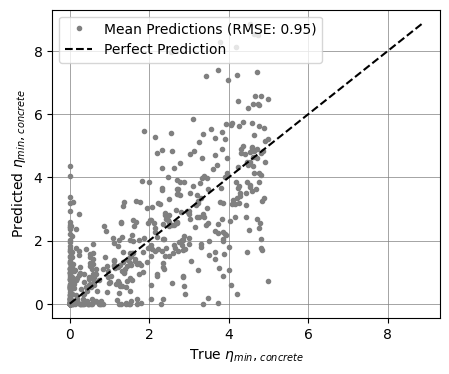

In [29]:
###### Calulate Metrics and Plot: For Critical Range #######

# Define the range
lower_bound = 0
upper_bound = 5

filtered_y_test_np, filtered_y_test_mean_pred_np=filter_values_within_range(y_true=y_test_np, y_pred=y_test_mean_pred_np, lb=lower_bound, ub=upper_bound)

# Calculate rmse
rmse_test_filtered = calculate_rmse(filtered_y_test_np, filtered_y_test_mean_pred_np)

#plot True vs Pred Plot
plot_true_vs_pred(y_true=filtered_y_test_np, y_pred=filtered_y_test_mean_pred_np, rmse_value=rmse_test_filtered, 
                    y_name='$\eta_{min},_{concrete}$' )

## 4.5 Uncertainty calibration

Tests made on the basis of this toolbox:\
[Uncertainty toolbox](https://github.com/uncertainty-toolbox/uncertainty-toolbox?tab=readme-ov-file)

Associated literature \
[Chung et al. - 2021 - Uncertainty Toolbox: an Open-Source Library for Assessing, Visualizing, and Improving Uncertainty Quantification](https://arxiv.org/abs/2109.10254) \
[Kuleshov et al. - 2018 - Accurate Uncertainties for Deep Learning Using Calibrated Regression](https://proceedings.mlr.press/v80/kuleshov18a.html)

#### Test example

In [ ]:
"""
This script produces the recalibration figures that appear in the README Recalibration
section:
https://github.com/uncertainty-toolbox/uncertainty-toolbox/blob/recal/README.md#recalibration
"""

import numpy as np
import matplotlib.pyplot as plt
import uncertainty_toolbox as uct


# Set plot style
uct.viz.set_style()
uct.viz.update_rc("text.usetex", True)  # Set to True for system latex
uct.viz.update_rc("font.size", 14)  # Set font size
uct.viz.update_rc("xtick.labelsize", 14)  # Set font size for xaxis tick labels
uct.viz.update_rc("ytick.labelsize", 14)  # Set font size for yaxis tick labels

# Set random seed
np.random.seed(11)

# Generate synthetic predictive uncertainty results
n_obs = 650
f, std, y, x = uct.synthetic_sine_heteroscedastic(n_obs)

# Save figure (set to True to save)
savefig = False

# List of predictive means and standard deviations
pred_mean_list = [f]

pred_std_list = [
    std * 0.5,  # overconfident
    std * 2.0,  # underconfident
]

# Loop through, make plots, and compute metrics
for i, pred_mean in enumerate(pred_mean_list):
    for j, pred_std in enumerate(pred_std_list):
        # Before recalibration
        exp_props, obs_props = uct.get_proportion_lists_vectorized(
            pred_mean, pred_std, y
        )
        mace = uct.mean_absolute_calibration_error(
            pred_mean, pred_std, y, recal_model=None
        )
        rmsce = uct.root_mean_squared_calibration_error(
            pred_mean, pred_std, y, recal_model=None
        )
        ma = uct.miscalibration_area(pred_mean, pred_std, y, recal_model=None)
        print("Before Recalibration:  ", end="")
        print("MACE: {:.5f}, RMSCE: {:.5f}, MA: {:.5f}".format(mace, rmsce, ma))

        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
        uct.plot_calibration(
            pred_mean,
            pred_std,
            y,
            exp_props=exp_props,
            obs_props=obs_props,
            ax=ax,
        )
        # uct.viz.save_figure(f"before_recal_{j}", "svg")

        # After recalibration
        recal_model = uct.iso_recal(exp_props, obs_props)
        recal_exp_props, recal_obs_props = uct.get_proportion_lists_vectorized(
            pred_mean, pred_std, y, recal_model=recal_model
        )
        mace = uct.mean_absolute_calibration_error(
            pred_mean, pred_std, y, recal_model=recal_model
        )
        rmsce = uct.root_mean_squared_calibration_error(
            pred_mean, pred_std, y, recal_model=recal_model
        )
        ma = uct.miscalibration_area(pred_mean, pred_std, y, recal_model=recal_model)
        print("After Recalibration:  ", end="")
        print("MACE: {:.5f}, RMSCE: {:.5f}, MA: {:.5f}".format(mace, rmsce, ma))

        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
        uct.plot_calibration(
            pred_mean,
            pred_std,
            y,
            exp_props=recal_exp_props,
            obs_props=recal_obs_props,
            ax=ax,
        )
        # uct.viz.save_figure(f"after_recal_{j}", "svg")

#### Adapt for current situation - on validation dataset

In [72]:
# Set random seed
np.random.seed(11)

# Generate synthetic predictive uncertainty results
n_obs = 650
f, std, y, x = uct.synthetic_sine_heteroscedastic(n_obs)

# Save figure (set to True to save)
savefig = False

# List of predictive means and standard deviations
pred_mean_list = [f]

pred_std_list = [
    std * 0.5,  # overconfident
    std * 2.0,  # underconfident
]

In [73]:
print(type(pred_mean_list[0]))
print(pred_mean_list[0].shape)

print(type(pred_std_list[0]))
print(pred_std_list[0].shape)

print(type(y))
print(y.shape)

<class 'numpy.ndarray'>
(650,)
<class 'numpy.ndarray'>
(650,)
<class 'numpy.ndarray'>
(650,)


In [75]:
pred_mean = y_val_mean_pred_np.flatten()
pred_std = y_val_std_pred_np.flatten()

y_val = y_val_np.flatten()

In [84]:
pred_std_as_df = pd.DataFrame(pred_std)

In [76]:
print(type(pred_mean))
print(pred_mean.shape)

print(type(pred_std))
print(pred_std.shape)

print(type(y_val))
print(y_val.shape)

<class 'numpy.ndarray'>
(1600,)
<class 'numpy.ndarray'>
(1600,)
<class 'numpy.ndarray'>
(1600,)


In [78]:
import uncertainty_toolbox as uct


# Set plot style
uct.viz.set_style()
uct.viz.update_rc("text.usetex", True)  # Set to True for system latex
uct.viz.update_rc("font.size", 14)  # Set font size
uct.viz.update_rc("xtick.labelsize", 14)  # Set font size for xaxis tick labels
uct.viz.update_rc("ytick.labelsize", 14)  # Set font size for yaxis tick labels

pred_mean = y_val_mean_pred_np.flatten()
pred_std = y_val_std_pred_np.flatten()

y_val = y_val_np.flatten()

# Before recalibration
exp_props, obs_props = uct.get_proportion_lists_vectorized(
    pred_mean, pred_std, y_val
)
mace = uct.mean_absolute_calibration_error(
    pred_mean, pred_std, y_val, recal_model=None
)
rmsce = uct.root_mean_squared_calibration_error(
    pred_mean, pred_std, y_val, recal_model=None
)
ma = uct.miscalibration_area(pred_mean, pred_std, y_val, recal_model=None)
print("Before Recalibration:  ", end="")
print("MACE: {:.5f}, RMSCE: {:.5f}, MA: {:.5f}".format(mace, rmsce, ma))

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
uct.plot_calibration(
    pred_mean,
    pred_std,
    y_val,
    exp_props=exp_props,
    obs_props=obs_props,
    ax=ax,
)
# uct.viz.save_figure(f"before_recal_{j}", "svg")

# # After recalibration
# recal_model = uct.iso_recal(exp_props, obs_props)
# recal_exp_props, recal_obs_props = uct.get_proportion_lists_vectorized(
#     pred_mean, pred_std, y, recal_model=recal_model
# )
# mace = uct.mean_absolute_calibration_error(
#     pred_mean, pred_std, y, recal_model=recal_model
# )
# rmsce = uct.root_mean_squared_calibration_error(
#     pred_mean, pred_std, y, recal_model=recal_model
# )
# ma = uct.miscalibration_area(pred_mean, pred_std, y, recal_model=recal_model)
# print("After Recalibration:  ", end="")
# print("MACE: {:.5f}, RMSCE: {:.5f}, MA: {:.5f}".format(mace, rmsce, ma))

# fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# uct.plot_calibration(
#     pred_mean,
#     pred_std,
#     y,
#     exp_props=recal_exp_props,
#     obs_props=recal_obs_props,
#     ax=ax,
# )
# # uct.viz.save_figure(f"after_recal_{j}", "svg")

AssertionError: 

## 5.  1D Parameter study validation

Here we plot the 1D paraemter studies calculated with the parameteric NLFE-Analysis-Pipeline against the mean prediction of the trained BNN model. Additionally we plot the uncertanty of the prediction.


### 5.1 Get features and targets

In [30]:
idx_s1=305
start_id = 0
end_id = 14
step='step_4'
var_par='beta'
unit=' [mm]'

df_xy_1=None

xy_file_name='CFBData\\{}_Batch\\{}_CFB_xy.csv'.format(idx_s1,idx_s1)

df_xy_1=pd.read_csv(xy_file_name)
# df_xy_1[[var_par,'eta_min_s','x_s','y_s','z_s','Location_s','GP_count_s','eta_min_c','x_c','y_c','z_c','Location_c','GP_count_c']]

### 5.2 Forward pass of features in BNN

In [31]:
#Extract features
x_names = ['L', 'b1',  't_p', 't_w', 'h_w', 'd1_plate', 'd4_plate', 'd2_plate', 's_plate', 'd1_walls', 'd4_walls', 's_walls', 'fcc', 's', 'beta', 'h_G'] # all 16 features
x_df=df_xy_1[x_names]

#Scale them
scaler = MinMaxScaler(feature_range=(0, 1))
x_scaled_np = scaler.fit_transform(x_df)
x_scaled_df=pd.DataFrame(data=x_scaled_np, columns=scaler.get_feature_names_out())

#transform into tensor
x_1D_tensor=torch.tensor(x_scaled_df.values, dtype=torch.float32)

In [33]:
##### make predictions ####
# Define number of predictions
n_predictions = 1000

# Perfrom multiple predictions on data --> get mean and std for each data point
y_1d_mean_pred_np, y_1d_std_pred_np, y_1d_pred_n_times = bnn_predict_with_uncertainty(model, x_1D_tensor, n=n_predictions, log_transform_back=False)
# val_mean_pred_1d, val_std_pred_1d = bnn_predict_with_uncertainty(model, x_1D_tensor, n=n_predictions)


### 5.3 Plot results

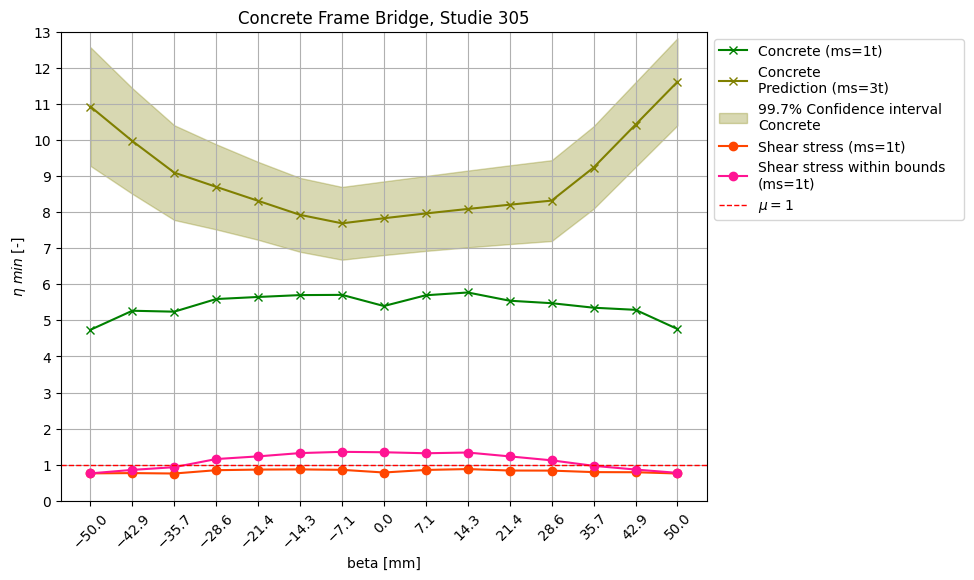

In [35]:
cm = 1/2.54

fig, ax = plt.subplots(figsize=(25*cm,15*cm))

#Bending
ax.plot(df_xy_1[var_par], df_xy_1['eta_min_c'], label='Concrete (ms=1t)', marker='x', color='green')

#Prediction
ax.plot(df_xy_1[var_par], y_1d_mean_pred_np[:,0], label='Concrete \nPrediction (ms=3t)', marker='x', color='olive')

#Confidence
ax.fill_between(df_xy_1[var_par], y_1d_mean_pred_np[:,0] - 3*y_1d_std_pred_np[:,0], y_1d_mean_pred_np[:,0] + 3*y_1d_std_pred_np[:,0], label = "99.7% Confidence interval \nConcrete", color = "olive", alpha = 0.3)

#Shear
ax.plot(df_xy_1[var_par], df_xy_1['eta_min_shear'],label='Shear stress (ms=1t)', marker='o', color='orangered')
ax.plot(df_xy_1[var_par], df_xy_1['eta_min_shear_reduced'],label='Shear stress within bounds   \n(ms=1t)', marker='o', color='deeppink')

ax.set(xlabel=var_par+unit, ylabel='$\eta \ min$ [-]',
       title='Concrete Frame Bridge, Studie {}'.format(idx_s1))

upper_lim = 13

ax.set_ylim(bottom=0,top=upper_lim)
ax.axhline(y=1, color='red', linestyle='--', linewidth=1, label='$\mu=1$')

ax.set_xticks(df_xy_1[var_par])
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=45)

ax.set_yticks(np.linspace(0,upper_lim,14))

ax.grid()
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
fig.tight_layout()

In [ ]:
filename = "1D_param_study_model_prediction_"
parameter = "beta"
fig.savefig("D:/ETHZ/IBK-SBB/VIII. BNN Data/Images/" + filename + parameter + ".png")


# FROM HERE below noch nicht aufgeräumt
#TODO ADD Antoines Validation plots here and add parameterstudie zu data folder

##### L-Parameter study

In [275]:
#import validation data
df_1d_L=pd.read_csv("TestData\\601_CFB_xy.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'TestData\\601_CFB_xy.csv'

In [25]:
x_data_1d=df_1d_L[x_names]
x_tensor_1d=torch.tensor(x_data_1d.values, dtype=torch.float32)

y_data_1d=df_1d_L[y_names]
y_tensor_1d = torch.tensor(y_data_1d.values,dtype=torch.float32)


x_data_1d.head()

NameError: name 'df_1d_L' is not defined

In [379]:
## normalise imoirted data
# Convert tensors to numpy arrays
x_data_1d_to_scale = x_tensor_1d.numpy()


# Scale the validation data using the same scaler as for fitted for the trainings set
x_data_1d_scaled = scaler.transform(x_data_1d_to_scale)

# Convert the scaled arrays back to tensors
x_tensor_1d_scaled = torch.tensor(x_data_1d_scaled, dtype=torch.float32)


print(x_tensor_1d_scaled)
print(y_tensor_1d)

tensor([[-1.0651e-04,  3.9531e-01,  2.0000e-01,  2.0002e-01,  1.9319e-01,
          7.0003e-01,  6.9997e-01,  9.9865e-02,  2.4992e-01,  1.9997e-01,
          7.0002e-01,  2.4997e-01, -4.8801e-01,  1.0217e-01,  5.5000e-01,
          5.8331e-01],
        [ 2.0305e-02,  3.9531e-01,  2.0000e-01,  2.0002e-01,  1.9319e-01,
          7.0003e-01,  6.9997e-01,  9.9865e-02,  2.4992e-01,  1.9997e-01,
          7.0002e-01,  2.4997e-01, -4.8801e-01,  1.0217e-01,  5.5000e-01,
          5.8331e-01],
        [ 4.0718e-02,  3.9531e-01,  2.0000e-01,  2.0002e-01,  1.9319e-01,
          7.0003e-01,  6.9997e-01,  9.9865e-02,  2.4992e-01,  1.9997e-01,
          7.0002e-01,  2.4997e-01, -4.8801e-01,  1.0217e-01,  5.5000e-01,
          5.8331e-01],
        [ 6.1130e-02,  3.9531e-01,  2.0000e-01,  2.0002e-01,  1.9319e-01,
          7.0003e-01,  6.9997e-01,  9.9865e-02,  2.4992e-01,  1.9997e-01,
          7.0002e-01,  2.4997e-01, -4.8801e-01,  1.0217e-01,  5.5000e-01,
          5.8331e-01],
        [ 8.1542e-02

c:\Users\kuhnso\AppData\Local\anaconda3\envs\BNNs\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [380]:
from model import predict
mean_values, std_values=predict(model=model, x_scaled=x_tensor_1d_scaled, n=10000)

In [381]:
from model import RMSE

mean_values_tensor = torch.tensor(mean_values).unsqueeze(1)

rmse=RMSE(y_pred=mean_values_tensor, y_true=y_tensor_1d, verbalize=True)
rmse_range=RMSE(y_pred=mean_values_tensor, y_true=y_tensor_1d, y_range=(0,5), verbalize=True)


Root Mean Squared Error (RMSE): 2.4198782444000244
A range is provided.
Root Mean Squared Error (RMSE): 1.6105395555496216


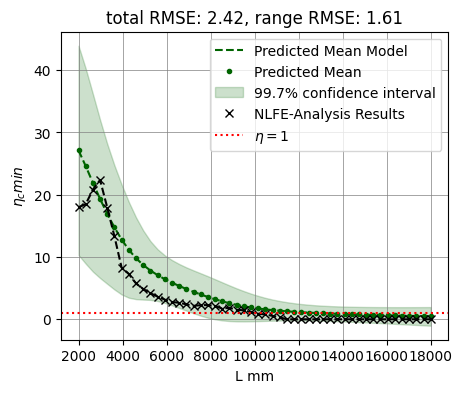

In [382]:
from plotting import single_para_strudy_perf

#x=torch.unsqueeze(x_tensor_1d[:, 2], dim=1).data.numpy()
variable='L'
unit='mm'
x=np.array(x_data_1d[variable]).reshape(-1,1)
y_pred=mean_values.reshape(-1,1)
y_true=y_tensor_1d.data.numpy()
y_std=std_values.reshape(-1,1)

single_para_strudy_perf(x, y_pred, y_true, y_std, variable=variable, unit=unit, rmse=rmse.item(),rmse_range=rmse_range.item())

##### t_p-Parameter study

In [383]:
#import validation data
df_1d_tp=pd.read_csv("TestData\\602_CFB_xy.csv")

x_data_1d=df_1d_tp[x_names]
x_tensor_1d=torch.tensor(x_data_1d.values, dtype=torch.float32)

y_data_1d=df_1d_tp[y_names]
y_tensor_1d = torch.tensor(y_data_1d.values,dtype=torch.float32)


x_tensor_1d

tensor([[5.8000e+03, 9.7200e+03, 2.0000e+02, 4.0000e+02, 2.5800e+03, 2.4000e+01,
         2.4000e+01, 1.2000e+01, 2.0000e+02, 1.4000e+01, 2.4000e+01, 2.0000e+02,
         1.2800e+01, 1.8179e-01, 5.0000e+00, 1.0000e+03],
        [5.8000e+03, 9.7200e+03, 2.2041e+02, 4.0000e+02, 2.5800e+03, 2.4000e+01,
         2.4000e+01, 1.2000e+01, 2.0000e+02, 1.4000e+01, 2.4000e+01, 2.0000e+02,
         1.2800e+01, 1.8179e-01, 5.0000e+00, 1.0000e+03],
        [5.8000e+03, 9.7200e+03, 2.4082e+02, 4.0000e+02, 2.5800e+03, 2.4000e+01,
         2.4000e+01, 1.2000e+01, 2.0000e+02, 1.4000e+01, 2.4000e+01, 2.0000e+02,
         1.2800e+01, 1.8179e-01, 5.0000e+00, 1.0000e+03],
        [5.8000e+03, 9.7200e+03, 2.6122e+02, 4.0000e+02, 2.5800e+03, 2.4000e+01,
         2.4000e+01, 1.2000e+01, 2.0000e+02, 1.4000e+01, 2.4000e+01, 2.0000e+02,
         1.2800e+01, 1.8179e-01, 5.0000e+00, 1.0000e+03],
        [5.8000e+03, 9.7200e+03, 2.8163e+02, 4.0000e+02, 2.5800e+03, 2.4000e+01,
         2.4000e+01, 1.2000e+01, 2.0000

In [384]:
## normalise imoirted data
# Convert tensors to numpy arrays
x_data_1d_to_scale = x_tensor_1d.numpy()


# Scale the validation data using the same scaler as for fitted for the trainings set
x_data_1d_scaled = scaler.transform(x_data_1d_to_scale)

# Convert the scaled arrays back to tensors
x_tensor_1d_scaled = torch.tensor(x_data_1d_scaled, dtype=torch.float32)


print(x_tensor_1d_scaled)
print(y_tensor_1d)

tensor([[ 2.3744e-01,  3.9531e-01, -6.5972e-05,  2.0002e-01,  1.9319e-01,
          7.0003e-01,  6.9997e-01,  9.9865e-02,  2.4992e-01,  1.9997e-01,
          7.0002e-01,  2.4997e-01, -4.8801e-01,  1.0217e-01,  5.5000e-01,
          5.8331e-01],
        [ 2.3744e-01,  3.9531e-01,  2.0349e-02,  2.0002e-01,  1.9319e-01,
          7.0003e-01,  6.9997e-01,  9.9865e-02,  2.4992e-01,  1.9997e-01,
          7.0002e-01,  2.4997e-01, -4.8801e-01,  1.0217e-01,  5.5000e-01,
          5.8331e-01],
        [ 2.3744e-01,  3.9531e-01,  4.0763e-02,  2.0002e-01,  1.9319e-01,
          7.0003e-01,  6.9997e-01,  9.9865e-02,  2.4992e-01,  1.9997e-01,
          7.0002e-01,  2.4997e-01, -4.8801e-01,  1.0217e-01,  5.5000e-01,
          5.8331e-01],
        [ 2.3744e-01,  3.9531e-01,  6.1178e-02,  2.0002e-01,  1.9319e-01,
          7.0003e-01,  6.9997e-01,  9.9865e-02,  2.4992e-01,  1.9997e-01,
          7.0002e-01,  2.4997e-01, -4.8801e-01,  1.0217e-01,  5.5000e-01,
          5.8331e-01],
        [ 2.3744e-01

c:\Users\kuhnso\AppData\Local\anaconda3\envs\BNNs\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [385]:
from model import predict
mean_values, std_values=predict(model=model, x_scaled=x_tensor_1d_scaled, n=1000)

In [386]:
from model import RMSE

mean_values_tensor = torch.tensor(mean_values).unsqueeze(1)

rmse=RMSE(y_pred=mean_values_tensor, y_true=y_tensor_1d, verbalize=True)
rmse_range=RMSE(y_pred=mean_values_tensor, y_true=y_tensor_1d, y_range=(0,5), verbalize=True)


Root Mean Squared Error (RMSE): 6.240512847900391
A range is provided.
Root Mean Squared Error (RMSE): 3.5423126220703125


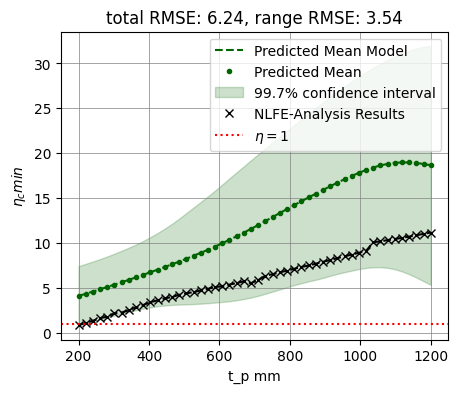

In [387]:
from plotting import single_para_strudy_perf

variable='t_p'
unit='mm'
x=np.array(x_data_1d[variable]).reshape(-1,1)
y_pred=mean_values.reshape(-1,1)
y_true=y_tensor_1d.data.numpy()
y_std=std_values.reshape(-1,1)

single_para_strudy_perf(x, y_pred, y_true, y_std, variable=variable, unit=unit, rmse=rmse.item(),rmse_range=rmse_range.item())